In [1]:
# Load the packages
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

In [2]:

info = pd.read_html('https://finance.yahoo.com/quote/%5EDJI/components?p=%5EDJI')[0]
tickers = info.Symbol.tolist()
tickers

['HD',
 'CAT',
 'NKE',
 'VZ',
 'MCD',
 'IBM',
 'JNJ',
 'DOW',
 'HON',
 'PG',
 'UNH',
 'MMM',
 'DIS',
 'AXP',
 'CSCO',
 'WBA',
 'V',
 'MRK',
 'INTC',
 'KO',
 'TRV',
 'AMGN',
 'WMT',
 'JPM',
 'CVX',
 'GS',
 'CRM',
 'MSFT',
 'BA',
 'AAPL']

In [3]:
from pandas_datareader.data import DataReader
start_date= '2000-01-01'
end_date='2019-01-01'
data = DataReader('IBM', 'yahoo', start_date, end_date)
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,116.000000,111.875000,112.437500,116.000000,10347700.0,73.656433
2000-01-04,114.500000,110.875000,114.000000,112.062500,8227800.0,71.156227
2000-01-05,119.750000,112.125000,112.937500,116.000000,12733200.0,73.656433
2000-01-06,118.937500,113.500000,118.000000,114.000000,7971900.0,72.386459
2000-01-07,117.937500,110.625000,117.250000,113.500000,11856700.0,72.069008
...,...,...,...,...,...,...
2018-12-24,111.000000,107.500000,109.900002,107.570000,3821400.0,98.946083
2018-12-26,111.389999,105.940002,108.000000,111.389999,6645800.0,102.459846
2018-12-27,113.779999,109.470001,109.989998,113.779999,6045600.0,104.658234


In [4]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [5]:
import copy
techindi1 = copy.deepcopy(data)
techindi1.reset_index(inplace=True,drop=False)
techindi1

,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-01-03,116.000000,111.875000,112.437500,116.000000,10347700.0,73.656433
1,2000-01-04,114.500000,110.875000,114.000000,112.062500,8227800.0,71.156227
2,2000-01-05,119.750000,112.125000,112.937500,116.000000,12733200.0,73.656433
3,2000-01-06,118.937500,113.500000,118.000000,114.000000,7971900.0,72.386459
4,2000-01-07,117.937500,110.625000,117.250000,113.500000,11856700.0,72.069008
...,...,...,...,...,...,...,...
4774,2018-12-24,111.000000,107.500000,109.900002,107.570000,3821400.0,98.946083
4775,2018-12-26,111.389999,105.940002,108.000000,111.389999,6645800.0,102.459846
4776,2018-12-27,113.779999,109.470001,109.989998,113.779999,6045600.0,104.658234
4777,2018-12-28,114.800003,112.500000,114.220001,113.029999,5117500.0,103.968369


In [6]:
def psar(techindi1, iaf = 0.02, maxaf = 0):
    length = len(techindi1)
    dates = (techindi1['Date'])
    high = (techindi1['High'])
    low = (techindi1['Low'])
    close = (techindi1['Close'])
    psar = techindi1['Close'][0:len(techindi1['Close'])]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = techindi1['Low'][0]
    hp = techindi1['High'][0]
    lp = techindi1['Low'][0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if techindi1['Low'][i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = techindi1['Low'][i]
                af = iaf
        else:
            if techindi1['High'][i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = techindi1['High'][i]
                af = iaf
        if not reverse:
            if bull:
                if techindi1['High'][i] > hp:
                    hp = techindi1['High'][i]
                    af = min(af + iaf, maxaf)
                if techindi1['Low'][i - 1] < psar[i]:
                    psar[i] = techindi['Low'][i - 1]
                if techindi1['Low'][i - 2] < psar[i]:
                    psar[i] = techindi1['Low'][i - 2]
            else:
                if techindi1['Low'][i] < lp:
                    lp = techindi1['Low'][i]
                    af = min(af + iaf, maxaf)
                if techindi1['High'][i - 1] > psar[i]:
                    psar[i] = techindi1['High'][i - 1]
                if techindi1['High'][i - 2] > psar[i]:
                    psar[i] = techindi1['High'][i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    #return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}
    #return psar, psarbear, psarbull
    techindi1['psar'] = psar
    #df['psarbear'] = psarbear
    #df['psarbull'] = psarbull

In [7]:
psar(techindi1)
techindi1

,Date,High,Low,Open,Close,Volume,Adj Close,psar
0,2000-01-03,116.000000,111.875000,112.437500,116.000000,10347700.0,73.656433,116.000000
1,2000-01-04,114.500000,110.875000,114.000000,112.062500,8227800.0,71.156227,112.062500
2,2000-01-05,119.750000,112.125000,112.937500,116.000000,12733200.0,73.656433,116.000000
3,2000-01-06,118.937500,113.500000,118.000000,112.125000,7971900.0,72.386459,112.125000
4,2000-01-07,117.937500,110.625000,117.250000,118.937500,11856700.0,72.069008,118.937500
...,...,...,...,...,...,...,...,...
4774,2018-12-24,111.000000,107.500000,109.900002,55.575998,3821400.0,98.946083,55.575998
4775,2018-12-26,111.389999,105.940002,108.000000,55.575998,6645800.0,102.459846,55.575998
4776,2018-12-27,113.779999,109.470001,109.989998,55.575998,6045600.0,104.658234,55.575998
4777,2018-12-28,114.800003,112.500000,114.220001,55.575998,5117500.0,103.968369,55.575998


In [8]:
techindi2=techindi1.drop(['High','Low','Open','Volume','Close','Adj Close'], axis=1)
techindi2 = techindi2.fillna(0)
techindi2

,Date,psar
0,2000-01-03,116.000000
1,2000-01-04,112.062500
2,2000-01-05,116.000000
3,2000-01-06,112.125000
4,2000-01-07,118.937500
...,...,...
4774,2018-12-24,55.575998
4775,2018-12-26,55.575998
4776,2018-12-27,55.575998
4777,2018-12-28,55.575998


In [9]:
def CMFlow(techindi, tf):
    CHMF = []
    MFMs = []
    MFVs = []
    x = tf
    
    while x < len(techindi):
        PeriodVolume = 0
        volRange = techindi['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        
        MFM = ((techindi['Close'][x] - techindi['Low'][x]) - (techindi['High'][x] - techindi['Close'][x])) / (techindi['High'][x] - techindi['Low'][x])
        MFV = MFM*PeriodVolume
        
        MFMs.append(MFM)
        MFVs.append(MFV)
        x+=1
    y = tf
    while y < len(MFVs):
        PeriodVolume = 0
        volRange = techindi['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        consider = MFVs[y-tf:y]
        tfsMFV = 0
        
        for eachMFV in consider:
            tfsMFV += eachMFV
        
        tfsCMF = tfsMFV/PeriodVolume
        CHMF.append(tfsCMF)
        y+=1
    return CHMF

In [10]:
import copy
techindi = copy.deepcopy(data)
techindi.reset_index(inplace=True,drop=False)
techindi['ret1']= np.log(techindi['Close']/techindi['Close'].shift(1))
techindi['ret11']= np.log(techindi['Close']/techindi['Close'].shift(2))
techindi['ret12']= np.log(techindi['Close']/techindi['Close'].shift(3))
techindi['ret13']= np.log(techindi['Close']/techindi['Close'].shift(4))
techindi['ret2']= np.log(techindi['High']/techindi['Open'].shift(1))
techindi['ret21']= np.log(techindi['High']/techindi['Open'].shift(2))
techindi['ret22']= np.log(techindi['High']/techindi['Open'].shift(3))
techindi['ret23']= np.log(techindi['High']/techindi['Open'].shift(4))
techindi['ret3']= np.log(techindi['Low']/techindi['Open'].shift(1))
techindi['ret31']= np.log(techindi['Low']/techindi['Open'].shift(2))
techindi['ret32']= np.log(techindi['Low']/techindi['Open'].shift(3))
techindi['ret33']= np.log(techindi['Low']/techindi['Open'].shift(4))
techindi['MA_7MA'] = techindi['Close'].rolling(window=7).mean()
techindi['MA_10MA'] = techindi['Close'].rolling(window=10).mean()
techindi['MA_50MA'] = techindi['Close'].rolling(window=35).mean()
techindi['MA_200MA'] = techindi['Close'].rolling(window=200).mean()
ewma = pd.Series.ewm
techindi['close_30EMA'] = ewma(techindi["Close"], span=30).mean()
techindi['Momentum'] = techindi['Close'] - techindi['Close'].shift(10)
techindi['VWAP'] = np.cumsum(techindi['Volume'] * (techindi['High'] + techindi['Low']+techindi['Close'])/3) / np.cumsum(techindi['Volume'])
techindi['ROC'] = ((techindi['Close'] - techindi['Close'].shift(10))/(techindi['Close'].shift(10)))*100
techindi['HL'] = techindi['High'] - techindi['Low']
techindi['absHC'] = abs(techindi['High'] - techindi['Close'].shift(1))
techindi['absLC'] = abs(techindi['Low'] - techindi['Close'].shift(1))
techindi['TR'] = techindi[['HL','absHC','absLC']].max(axis=1)
techindi['ATR'] = techindi['TR'].rolling(window=14).mean()
techindi['rsidex']= computeRSI(data['Close'], 14)
new = (techindi['Volume'] * (~techindi['Close'].diff().le(0) * 2 -1)).cumsum()
techindi['OBV'] = new
def WillR(df):
    highest_high = df['High'].rolling(window=14,center=False).max()
    lowest_low = df['Low'].rolling(window=14,center=False).min()
    df['WillR'] = (-100) * ((highest_high - df['Close']) / (highest_high - lowest_low))
WillR(techindi)
techindi['26_ema'] = techindi['Close'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
techindi['12_ema'] = techindi['Close'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
techindi['MACD'] = techindi['12_ema'] - techindi['26_ema']
listofzeros = [0] * 40
CHMF = CMFlow(techindi, 20)
if len(CHMF)==0:
    CHMF = [0] * techindi.shape[0]
    techindi['Chaikin_MF'] = CHMF
else:
    techindi['Chaikin_MF'] = listofzeros+CHMF

techindi['stock_daily_returns'] = techindi['Close'].pct_change()
techindi['daily_log_returns'] = np.log(techindi['stock_daily_returns']+1)
techindi = techindi.fillna(0)
techindi

,Date,High,Low,Open,Close,Volume,Adj Close,ret1,ret11,ret12,...,ATR,rsidex,OBV,WillR,26_ema,12_ema,MACD,Chaikin_MF,stock_daily_returns,daily_log_returns
0,2000-01-03,116.000000,111.875000,112.437500,116.000000,10347700.0,73.656433,0.000000,0.000000,0.000000,...,0.000000,0.0,10347700.0,0.000000,116.000000,116.000000,0.000000,0.000000,0.000000,0.000000
1,2000-01-04,114.500000,110.875000,114.000000,112.062500,8227800.0,71.156227,-0.034533,0.000000,0.000000,...,0.000000,0.0,2119900.0,0.000000,113.955529,113.867187,-0.088341,0.000000,-0.033944,-0.034533
2,2000-01-05,119.750000,112.125000,112.937500,116.000000,12733200.0,73.656433,0.034533,0.000000,0.000000,...,0.000000,0.0,14853100.0,0.000000,114.690087,114.699625,0.009537,0.000000,0.035137,0.034533
3,2000-01-06,118.937500,113.500000,118.000000,114.000000,7971900.0,72.386459,-0.017392,0.017142,-0.017392,...,0.000000,0.0,6881200.0,0.000000,114.497169,114.478781,-0.018389,0.000000,-0.017241,-0.017392
4,2000-01-07,117.937500,110.625000,117.250000,113.500000,11856700.0,72.069008,-0.004396,-0.021787,0.012746,...,0.000000,0.0,-4975500.0,0.000000,114.265922,114.212849,-0.053072,0.000000,-0.004386,-0.004396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,2018-12-24,111.000000,107.500000,109.900002,107.570000,3821400.0,98.946083,-0.030848,-0.049423,-0.079148,...,3.603571,0.0,-62335100.0,-99.598165,118.925825,115.692279,-3.233546,-2.694766,-0.030377,-0.030848
4775,2018-12-26,111.389999,105.940002,108.000000,111.389999,6645800.0,102.459846,0.034896,0.004048,-0.014527,...,3.708571,0.0,-55689300.0,-69.906147,118.367616,115.030390,-3.337226,-2.659680,0.035512,0.034896
4776,2018-12-27,113.779999,109.470001,109.989998,113.779999,6045600.0,104.658234,0.021229,0.056125,0.025277,...,3.687143,0.0,-49643700.0,-56.709022,118.027792,114.838022,-3.189770,-2.242289,0.021456,0.021229
4777,2018-12-28,114.800003,112.500000,114.220001,113.029999,5117500.0,103.968369,-0.006613,0.014616,0.049511,...,3.481428,0.0,-54761200.0,-60.324576,117.657585,114.559864,-3.097721,-2.720125,-0.006592,-0.006613


In [11]:
techindi3 = pd.merge(techindi, techindi2)
techindi3

,Date,High,Low,Open,Close,Volume,Adj Close,ret1,ret11,ret12,...,rsidex,OBV,WillR,26_ema,12_ema,MACD,Chaikin_MF,stock_daily_returns,daily_log_returns,psar
0,2000-01-03,116.000000,111.875000,112.437500,116.000000,10347700.0,73.656433,0.000000,0.000000,0.000000,...,0.0,10347700.0,0.000000,116.000000,116.000000,0.000000,0.000000,0.000000,0.000000,116.000000
1,2000-01-04,114.500000,110.875000,114.000000,112.062500,8227800.0,71.156227,-0.034533,0.000000,0.000000,...,0.0,2119900.0,0.000000,113.955529,113.867187,-0.088341,0.000000,-0.033944,-0.034533,112.062500
2,2000-01-05,119.750000,112.125000,112.937500,116.000000,12733200.0,73.656433,0.034533,0.000000,0.000000,...,0.0,14853100.0,0.000000,114.690087,114.699625,0.009537,0.000000,0.035137,0.034533,116.000000
3,2000-01-06,118.937500,113.500000,118.000000,114.000000,7971900.0,72.386459,-0.017392,0.017142,-0.017392,...,0.0,6881200.0,0.000000,114.497169,114.478781,-0.018389,0.000000,-0.017241,-0.017392,112.125000
4,2000-01-07,117.937500,110.625000,117.250000,113.500000,11856700.0,72.069008,-0.004396,-0.021787,0.012746,...,0.0,-4975500.0,0.000000,114.265922,114.212849,-0.053072,0.000000,-0.004386,-0.004396,118.937500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,2018-12-24,111.000000,107.500000,109.900002,107.570000,3821400.0,98.946083,-0.030848,-0.049423,-0.079148,...,0.0,-62335100.0,-99.598165,118.925825,115.692279,-3.233546,-2.694766,-0.030377,-0.030848,55.575998
4775,2018-12-26,111.389999,105.940002,108.000000,111.389999,6645800.0,102.459846,0.034896,0.004048,-0.014527,...,0.0,-55689300.0,-69.906147,118.367616,115.030390,-3.337226,-2.659680,0.035512,0.034896,55.575998
4776,2018-12-27,113.779999,109.470001,109.989998,113.779999,6045600.0,104.658234,0.021229,0.056125,0.025277,...,0.0,-49643700.0,-56.709022,118.027792,114.838022,-3.189770,-2.242289,0.021456,0.021229,55.575998
4777,2018-12-28,114.800003,112.500000,114.220001,113.029999,5117500.0,103.968369,-0.006613,0.014616,0.049511,...,0.0,-54761200.0,-60.324576,117.657585,114.559864,-3.097721,-2.720125,-0.006592,-0.006613,55.575998


In [12]:
input_feature = techindi3[['ret1','ret11','ret12','ret13','ret2','ret21','ret22','ret23','ret3','ret31','ret32','ret33','MA_7MA','MA_10MA','MA_50MA','MA_200MA','close_30EMA','Momentum','VWAP','ROC','TR','ATR','rsidex','OBV','WillR','26_ema','12_ema','MACD','Chaikin_MF','stock_daily_returns','daily_log_returns','psar','Close']]
input_data = input_feature.values

In [13]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
input_data[:,:] = scaler.fit_transform(input_data[:,:])

In [14]:
#splitting data
# X is the input variable
X = techindi3[['ret1','ret11','ret12','ret13','ret2','ret21','ret22','ret23','ret3','ret31','ret32','ret33','MA_7MA','MA_10MA','MA_50MA','MA_200MA','close_30EMA','Momentum','VWAP','ROC','psar','TR','ATR','rsidex','OBV','WillR','26_ema','12_ema','MACD','Chaikin_MF','stock_daily_returns','daily_log_returns']]

# Y is the target or output variable
y = techindi3['Close']

In [15]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=False)

In [16]:
kf.split(X)

<generator object _BaseKFold.split at 0x000000001BDA2F48>

In [17]:
print("Train: ", "TEST:")
for train_index, test_index in kf.split(X):
     print(train_index, test_index)

Train:  TEST:
[ 956  957  958 ... 4776 4777 4778] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 

In [18]:
# Iterate over each train-test split
for train_index, test_index in kf.split(X):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
   

In [19]:
X_train1=np.array(X_train)
X_test1=np.array(X_test)
y_train1=np.array(y_train)
y_test1=np.array(y_test)

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from math import sqrt
from sklearn.model_selection import GridSearchCV

In [21]:
lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(y_train1)
print(training_scores_encoded)
print(utils.multiclass.type_of_target(y_train1))
print(utils.multiclass.type_of_target(y_train1.astype('int')))
print(utils.multiclass.type_of_target(training_scores_encoded))

[1622 1494 1622 ... 2201 2222 2221]
continuous
multiclass
multiclass


In [22]:
sel= RFE(GradientBoostingRegressor(n_estimators=100,random_state=0),n_features_to_select=15)
sel.fit(X_train1,y_train1)

RFE(estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                        criterion='friedman_mse', init=None,
                                        learning_rate=0.1, loss='ls',
                                        max_depth=3, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_iter_no_change=None,
                                        presort='deprecated', random_state=0,
                                        subsample=1.0, tol=0.0001,
                                        validation_fraction=0.1, verbose=0,
                                        warm_start=False),
    n_feat

In [23]:
sel.get_support()

array([False,  True,  True,  True, False, False, False, False, False,
       False, False,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True, False, False, False,  True,  True,  True,
        True, False, False, False, False])

In [24]:
features=X_train.columns[sel.get_support()]
features

Index(['ret11', 'ret12', 'ret13', 'ret33', 'MA_7MA', 'MA_10MA', 'MA_200MA',
       'close_30EMA', 'Momentum', 'ROC', 'psar', 'OBV', 'WillR', '26_ema',
       '12_ema'],
      dtype='object')

In [25]:
X_train_rfe= sel.transform(X_train1)
X_test_rfe= sel.transform(X_test1)

In [26]:
from sklearn import metrics 
def run_randomForest(X_train1,X_test1,y_train1,y_test1):
    clf = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X_train1,y_train1)
    y_pred=clf.predict(X_test1)
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))
   

In [27]:
for index in range (1, 33):
    sel= RFE(GradientBoostingRegressor(n_estimators=100,random_state=0), n_features_to_select= index)
    sel.fit(X_train1,y_train1)
    X_train_rfe= sel.transform(X_train1)
    X_test_rfe= sel.transform(X_test1)
    print('Selected Feature:', index)
    run_randomForest(X_train_rfe,X_test_rfe,y_train1,y_test1)
    print()

Selected Feature: 1
Root Mean Squared Error: 3.675952349233679

Selected Feature: 2
Root Mean Squared Error: 5.466359545542445

Selected Feature: 3
Root Mean Squared Error: 5.066805364537178

Selected Feature: 4
Root Mean Squared Error: 4.713204802290495

Selected Feature: 5
Root Mean Squared Error: 3.415383566586033

Selected Feature: 6
Root Mean Squared Error: 3.302358994963784

Selected Feature: 7
Root Mean Squared Error: 3.189229656909942

Selected Feature: 8
Root Mean Squared Error: 3.353804290675356

Selected Feature: 9
Root Mean Squared Error: 2.924476615108707

Selected Feature: 10
Root Mean Squared Error: 2.934634749024284

Selected Feature: 11
Root Mean Squared Error: 2.916840723451576

Selected Feature: 12
Root Mean Squared Error: 2.975607844012502

Selected Feature: 13
Root Mean Squared Error: 2.844329157974101

Selected Feature: 14
Root Mean Squared Error: 2.749837478499554

Selected Feature: 15
Root Mean Squared Error: 2.7369069627676135

Selected Feature: 16
Root Mean Sq

In [28]:
sel= RFE(GradientBoostingRegressor(n_estimators=100,random_state=0), n_features_to_select= 15)
sel.fit(X_train1,y_train1)
X_train_rfe= sel.transform(X_train1)
X_test_rfe= sel.transform(X_test1)
print('Selected Feature:', 14)
run_randomForest(X_train_rfe,X_test_rfe,y_train1,y_test1)
print()

Selected Feature: 14
Root Mean Squared Error: 2.7369069627676135



In [29]:
features=X_train.columns[sel.get_support()]
features

Index(['ret11', 'ret12', 'ret13', 'ret33', 'MA_7MA', 'MA_10MA', 'MA_200MA',
       'close_30EMA', 'Momentum', 'ROC', 'psar', 'OBV', 'WillR', '26_ema',
       '12_ema'],
      dtype='object')

In [ ]:
'ret11', 'ret12', 'ret13', 'ret33', 'MA_7MA', 'MA_10MA', 'MA_200MA',
       'close_30EMA', 'Momentum', 'ROC', 'psar', 'OBV', 'WillR', '26_ema',
       '12_ema'

In [30]:
a=copy.deepcopy(techindi3)

In [31]:
for col in a.columns: 
    print(col)

Date
High
Low
Open
Close
Volume
Adj Close
ret1
ret11
ret12
ret13
ret2
ret21
ret22
ret23
ret3
ret31
ret32
ret33
MA_7MA
MA_10MA
MA_50MA
MA_200MA
close_30EMA
Momentum
VWAP
ROC
HL
absHC
absLC
TR
ATR
rsidex
OBV
WillR
26_ema
12_ema
MACD
Chaikin_MF
stock_daily_returns
daily_log_returns
psar


In [54]:
b=a.drop(['Date','ret1','ret2','ret21','ret22','ret23','ret3','ret31','ret32','MA_50MA','HL','VWAP','absHC','absLC','TR','ATR','rsidex','MACD','Chaikin_MF','stock_daily_returns','daily_log_returns'], axis = 1) 
b 

,High,Low,Open,Close,Volume,Adj Close,ret11,ret12,ret13,ret33,...,MA_10MA,MA_200MA,close_30EMA,Momentum,ROC,OBV,WillR,26_ema,12_ema,psar
0,116.000000,111.875000,112.437500,116.000000,10347700.0,73.656433,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,116.000000,0.000000,0.000000,10347700.0,0.000000,116.000000,116.000000,116.000000
1,114.500000,110.875000,114.000000,112.062500,8227800.0,71.156227,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,113.965625,0.000000,0.000000,2119900.0,0.000000,113.955529,113.867187,112.062500
2,119.750000,112.125000,112.937500,116.000000,12733200.0,73.656433,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,114.689444,0.000000,0.000000,14853100.0,0.000000,114.690087,114.699625,116.000000
3,118.937500,113.500000,118.000000,114.000000,7971900.0,72.386459,0.017142,-0.017392,0.000000,0.000000,...,0.000000,0.00000,114.499477,0.000000,0.000000,6881200.0,0.000000,114.497169,114.478781,112.125000
4,117.937500,110.625000,117.250000,113.500000,11856700.0,72.069008,-0.021787,0.012746,-0.021787,-0.016251,...,0.000000,0.00000,114.272072,0.000000,0.000000,-4975500.0,0.000000,114.265922,114.212849,118.937500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,111.000000,107.500000,109.900002,107.570000,3821400.0,98.946083,-0.049423,-0.079148,-0.081036,-0.083828,...,116.339001,140.91025,119.740368,-13.559998,-11.194583,-62335100.0,-99.598165,118.925825,115.692279,55.575998
4775,111.389999,105.940002,108.000000,111.389999,6645800.0,102.459846,0.004048,-0.014527,-0.044253,-0.100582,...,115.389001,140.66590,119.201635,-9.500000,-7.858384,-55689300.0,-69.906147,118.367616,115.030390,55.575998
4776,113.779999,109.470001,109.989998,113.779999,6045600.0,104.658234,0.056125,0.025277,0.006702,-0.055350,...,114.651000,140.43820,118.851852,-7.380005,-6.091123,-49643700.0,-56.709022,118.027792,114.838022,55.575998
4777,114.800003,112.500000,114.220001,113.029999,5117500.0,103.968369,0.014616,0.049511,0.018664,0.000000,...,113.881000,140.21275,118.476248,-7.700005,-6.377872,-54761200.0,-60.324576,117.657585,114.559864,55.575998


In [55]:
values=b.values
values=values.astype('float32')
values

array([[116.      , 111.875   , 112.4375  , ..., 116.      , 116.      ,
        116.      ],
       [114.5     , 110.875   , 114.      , ..., 113.95553 , 113.86719 ,
        112.0625  ],
       [119.75    , 112.125   , 112.9375  , ..., 114.69009 , 114.69962 ,
        116.      ],
       ...,
       [113.78    , 109.47    , 109.99    , ..., 118.027794, 114.83802 ,
         55.575996],
       [114.8     , 112.5     , 114.22    , ..., 117.657585, 114.55987 ,
         55.575996],
       [114.35    , 112.42    , 113.33    , ..., 117.362206, 114.42296 ,
         55.575996]], dtype=float32)

In [56]:
b.shape

(4779, 21)

In [57]:
print("Min;", np.min(values))
print("Max;", np.max(values))

Min; -247422400.0
Max; 241847000.0


In [58]:
def ts(b, look_back=60, pred_col=4):
    t=b.copy()
    t["id"]= range(1, len(t)+1)

    t=t.iloc[:-look_back, :]
    t.set_index('id', inplace=True)
    pred_value=b.copy()
    pred_value=pred_value.iloc[look_back:, pred_col]
    pred_value.columns=["Pred"]
    pred_value=pd.DataFrame(pred_value)
    
    pred_value["id"]=range (1, len(pred_value)+1)
    pred_value.set_index('id', inplace=True)
    final_df= pd.concat([t, pred_value], axis=1)
    
    return final_df
    

In [59]:
values = pd.DataFrame(values)
arr_df= ts(values, 60,4)
arr_df.fillna(0, inplace=True)

arr_df.columns= ['v1(t-60)','v2(t-60)','v3(t-60)','v4(t-60)',
                      'v5(t-60)','v6(t-60)','v7(t-60)','v8(t-60)',
                      'v9(t-60)','v10(t-60)','v11(t-60)','v12(t-60)',
                      'v13(t-60)','v14(t-60)','v15(t-60)','v16(t-60)',
                      'v17(t-60)','v18(t-60)','v19(t-60)','v20(t-60)',
                      'v21(t-60)','v1(t)']
print(arr_df.head(4))

    v1(t-60)  v2(t-60)  v3(t-60)  v4(t-60)    v5(t-60)   v6(t-60)  v7(t-60)  \
id                                                                            
1   116.0000   111.875  112.4375  116.0000  10347700.0  73.656433  0.000000   
2   114.5000   110.875  114.0000  112.0625   8227800.0  71.156227  0.000000   
3   119.7500   112.125  112.9375  116.0000  12733200.0  73.656433  0.000000   
4   118.9375   113.500  118.0000  114.0000   7971900.0  72.386459  0.017142   

    v8(t-60)  v9(t-60)  v10(t-60)  ...  v13(t-60)   v14(t-60)  v15(t-60)  \
id                                 ...                                     
1   0.000000       0.0        0.0  ...        0.0  116.000000        0.0   
2   0.000000       0.0        0.0  ...        0.0  113.965622        0.0   
3   0.000000       0.0        0.0  ...        0.0  114.689445        0.0   
4  -0.017392       0.0        0.0  ...        0.0  114.499474        0.0   

    v16(t-60)   v17(t-60)  v18(t-60)   v19(t-60)   v20(t-60)  v21(t-

In [60]:
print(arr_df.describe())

          v1(t-60)     v2(t-60)     v3(t-60)     v4(t-60)    v5(t-60)  \
count  4719.000000  4719.000000  4719.000000  4719.000000      4719.0   
mean    130.283630   128.048538   129.114517   129.183685   6222596.5   
std      39.635319    39.495270    39.564301    39.572491   3305756.0   
min      56.700001    54.009998    54.650002    55.070000   1027500.0   
25%      93.790001    92.165001    92.910000    92.955002   3968950.0   
50%     123.750000   121.160004   122.449997   122.500000   5415700.0   
75%     162.339996   160.150002   161.330002   161.379997   7566150.0   
max     215.899994   214.300003   215.380005   215.800003  41207300.0   

          v6(t-60)     v7(t-60)     v8(t-60)     v9(t-60)    v10(t-60)  ...  \
count  4719.000000  4719.000000  4719.000000  4719.000000  4719.000000  ...   
mean     94.727600     0.000126     0.000185     0.000245    -0.008644  ...   
std      35.620731     0.022503     0.027235     0.031311     0.033467  ...   
min      35.497597    -0.1

In [61]:
arr_df.shape

(4719, 22)

In [62]:
val=arr_df.values
train_sample=int(len(b)*0.8)
train= val[:train_sample, :]
test= val[train_sample:, :]
print(train.shape, test.shape)

(3823, 22) (896, 22)


In [63]:
train= pd.DataFrame(train)
test= pd.DataFrame(test)

In [64]:
test

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,157.289993,155.369995,156.199997,156.960007,3311700.0,122.776688,0.017222,-0.006477,0.001020,-0.020387,...,173.770508,158.877533,-4.069992,-2.527474,-56443500.0,-66.852783,158.831177,158.172821,55.575996,3464000.0
1,160.699997,155.800003,156.850006,159.809998,5738800.0,125.006027,0.017230,0.035216,0.011517,-0.003012,...,173.641098,158.937683,0.389999,0.244636,-50704700.0,-27.896467,158.903687,158.424698,55.575996,3065100.0
2,160.919998,158.809998,159.699997,159.809998,3878600.0,125.006027,0.017995,0.017230,0.035216,0.008537,...,173.518295,158.993973,-1.369995,-0.849978,-54583300.0,-24.941484,158.970825,158.637817,55.575996,4245700.0
3,163.000000,160.350006,160.949997,162.880005,9006400.0,127.407402,0.019028,0.037023,0.036259,0.033611,...,173.410156,159.244675,4.380005,2.763410,-45576900.0,-1.249948,159.260391,159.290466,55.575996,3249800.0
4,165.350006,162.729996,162.770004,164.630005,5930100.0,128.776321,0.029715,0.029715,0.047710,0.040955,...,173.303406,159.592117,3.860001,2.400946,-39646800.0,-6.025109,159.658142,160.111938,55.575996,2863000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,152.389999,151.160004,152.009995,151.500000,3477600.0,137.601700,0.017244,0.009750,0.000991,-0.002115,...,150.207352,147.950500,2.550003,1.711986,16337800.0,-22.839563,148.219238,149.600403,55.575996,3821400.0
892,151.630005,150.789993,151.160004,151.210007,3305800.0,137.338303,-0.002642,0.015328,0.007834,-0.002054,...,150.179703,148.160782,2.880005,1.941620,13032000.0,-26.419725,148.440781,149.848038,55.575996,6645800.0
893,153.419998,151.710007,151.710007,153.000000,3757400.0,138.964081,0.009852,0.009126,0.027096,0.011936,...,150.175156,148.472992,5.059998,3.420304,16789400.0,-5.683331,148.778503,150.332962,55.575996,6045600.0
894,153.839996,152.500000,152.990005,153.750000,3029900.0,139.645264,0.016658,0.014742,0.014016,0.000656,...,150.173904,148.813446,5.190002,3.493540,19819300.0,-1.339231,149.146759,150.858658,55.575996,5117500.0


In [65]:
X, y= train ,test
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
X = scaler.fit_transform(train)
print(X)
print('\n')
print(X.shape)

[[0.37248746 0.3610019  0.35953146 ... 0.3706538  0.76599425 0.1564169 ]
 [0.36306533 0.35476327 0.36925274 ... 0.35671693 0.7173396  0.20235291]
 [0.39604273 0.36256158 0.3626423  ... 0.3621565  0.76599425 0.17391077]
 ...
 [0.6408292  0.63796866 0.63224036 ... 0.6544046  0.01935065 0.06797445]
 [0.6332915  0.6200636  0.6396441  ... 0.6492339  0.01935065 0.05894504]
 [0.63059044 0.6287978  0.62465    ... 0.64767355 0.01935065 0.09091633]]


(3823, 22)


In [66]:
X_train = []
y_train = []
for i in range(60, X.shape[0]):
    X_train.append(X[i-60:i])
    y_train.append(X[i, 0])
    if i<=61:
        print(X_train)
        print('\n')
        print(y_train)
        print()

[array([[0.37248746, 0.3610019 , 0.35953146, ..., 0.3706538 , 0.76599425,
        0.1564169 ],
       [0.36306533, 0.35476327, 0.36925274, ..., 0.35671693, 0.7173396 ,
        0.20235291],
       [0.39604273, 0.36256158, 0.3626423 , ..., 0.3621565 , 0.76599425,
        0.17391077],
       ...,
       [0.41174623, 0.38088775, 0.37780744, ..., 0.3466242 , 0.87048596,
        0.15122773],
       [0.44943467, 0.44054526, 0.4376905 , ..., 0.36125457, 0.5621081 ,
        0.13587673],
       [0.4415829 , 0.42455858, 0.4423567 , ..., 0.36923546, 0.5692131 ,
        0.09521202]], dtype=float32)]


[0.41292402]

[array([[0.37248746, 0.3610019 , 0.35953146, ..., 0.3706538 , 0.76599425,
        0.1564169 ],
       [0.36306533, 0.35476327, 0.36925274, ..., 0.35671693, 0.7173396 ,
        0.20235291],
       [0.39604273, 0.36256158, 0.3626423 , ..., 0.3621565 , 0.76599425,
        0.17391077],
       ...,
       [0.41174623, 0.38088775, 0.37780744, ..., 0.3466242 , 0.87048596,
        0.15122773],
 

In [67]:
X_train,y_train=np.array(X_train), np.array(y_train)
print(X_train.shape,y_train.shape)

(3763, 60, 22) (3763,)


In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [69]:
#Model creation
import tensorflow as tf
model_lstm=tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(units=75,return_sequences= True, input_shape=(X_train.shape[1], X_train.shape[2])))

model_lstm.add(tf.keras.layers.LSTM(units=30,return_sequences= True))


model_lstm.add(tf.keras.layers.LSTM(units=30))

model_lstm.add(tf.keras.layers.Dense(units=1))
model_lstm.compile(loss = 'mae' , optimizer = 'adam')
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 75)            29400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 30)            12720     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 49,471
Trainable params: 49,471
Non-trainable params: 0
_________________________________________________________________


In [70]:
look_back=train.tail(60)
data =look_back.append(test)
print(data)

              0           1           2           3          4           5   \
3763  153.309998  151.110001  151.520004  151.929993  5131000.0  118.014297   
3764  157.679993  153.300003  153.580002  157.679993  7302400.0  122.480675   
3765  160.410004  157.490005  157.490005  158.509995  8864900.0  123.125420   
3766  161.910004  158.330002  158.330002  161.440002  4682500.0  125.401329   
3767  162.899994  161.610001  162.229996  162.240005  4043300.0  126.022812   
...          ...         ...         ...         ...        ...         ...   
891   152.389999  151.160004  152.009995  151.500000  3477600.0  137.601700   
892   151.630005  150.789993  151.160004  151.210007  3305800.0  137.338303   
893   153.419998  151.710007  151.710007  153.000000  3757400.0  138.964081   
894   153.839996  152.500000  152.990005  153.750000  3029900.0  139.645264   
895   154.360001  152.800003  154.000000  153.220001  3315300.0  139.163879   

            6         7         8         9   ...  

In [71]:

inputs = scaler.transform(data)
inputs

array([[0.6068467 , 0.605777  , 0.6026877 , ..., 0.64235705, 0.01935065,
        0.05684946],
       [0.6342964 , 0.6194398 , 0.6155042 , ..., 0.6424578 , 0.01935065,
        0.11725543],
       [0.6514448 , 0.6455799 , 0.63983077, ..., 0.6433775 , 0.01935065,
        0.07095854],
       ...,
       [0.6075376 , 0.60952026, 0.60386986, ..., 0.59500295, 0.01935065,
        0.1248911 ],
       [0.61017585, 0.6144488 , 0.6118335 , ..., 0.5984381 , 0.01935065,
        0.10179244],
       [0.6134422 , 0.61632043, 0.6181173 , ..., 0.60081196, 0.01935065,
        0.09844001]], dtype=float32)

In [72]:
X_test = []
y_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])
    if i<=61:
        print(X_test)
        print('\n')
        print(y_test)
        print()

[array([[0.6068467 , 0.605777  , 0.6026877 , ..., 0.64235705, 0.01935065,
        0.05684946],
       [0.6342964 , 0.6194398 , 0.6155042 , ..., 0.6424578 , 0.01935065,
        0.11725543],
       [0.6514448 , 0.6455799 , 0.63983077, ..., 0.6433775 , 0.01935065,
        0.07095854],
       ...,
       [0.6408292 , 0.63796866, 0.63224036, ..., 0.6544046 , 0.01935065,
        0.06797445],
       [0.6332915 , 0.6200636 , 0.6396441 , ..., 0.6492339 , 0.01935065,
        0.05894504],
       [0.63059044, 0.6287978 , 0.62465   , ..., 0.64767355, 0.01935065,
        0.09091633]], dtype=float32)]


[0.63184667]

[array([[0.6068467 , 0.605777  , 0.6026877 , ..., 0.64235705, 0.01935065,
        0.05684946],
       [0.6342964 , 0.6194398 , 0.6155042 , ..., 0.6424578 , 0.01935065,
        0.11725543],
       [0.6514448 , 0.6455799 , 0.63983077, ..., 0.6433775 , 0.01935065,
        0.07095854],
       ...,
       [0.6408292 , 0.63796866, 0.63224036, ..., 0.6544046 , 0.01935065,
        0.06797445],
 

In [73]:
X_test,y_test=np.array(X_test), np.array(y_test)
print(X_test.shape,y_test.shape)

(896, 60, 22) (896,)


In [74]:
y_test

array([0.63184667, 0.6532663 , 0.6546483 , 0.66771364, 0.682475  ,
       0.67958546, 0.6682161 , 0.6567211 , 0.65452266, 0.67148244,
       0.6635051 , 0.65276384, 0.6648241 , 0.6664573 , 0.67298996,
       0.67116845, 0.6643845 , 0.66978645, 0.673995  , 0.6660805 ,
       0.6800252 , 0.6738694 , 0.66055286, 0.69057786, 0.6952262 ,
       0.68655777, 0.723681  , 0.71702266, 0.72104275, 0.7411432 ,
       0.7439071 , 0.7385678 , 0.73680913, 0.75125635, 0.73825383,
       0.73712313, 0.7241206 , 0.73260057, 0.73046494, 0.72104275,
       0.7288946 , 0.7393216 , 0.73938453, 0.7336056 , 0.7352387 ,
       0.7395729 , 0.7376884 , 0.7329774 , 0.725     , 0.7272613 ,
       0.7232412 , 0.72016335, 0.71821606, 0.7145101 , 0.7214824 ,
       0.7154523 , 0.7048367 , 0.69459796, 0.68668354, 0.70785177,
       0.71444726, 0.7010051 , 0.69277644, 0.6953517 , 0.6981784 ,
       0.7036432 , 0.70175886, 0.7012563 , 0.71149504, 0.70439696,
       0.6999372 , 0.69164574, 0.682475  , 0.673995  , 0.68410

Train on 3386 samples, validate on 377 samples
Epoch 1/100
3386/3386 [==============================] - 74s 22ms/sample - loss: 0.0758 - val_loss: 0.0932
Epoch 2/100
3386/3386 [==============================] - 44s 13ms/sample - loss: 0.0725 - val_loss: 0.0993
Epoch 3/100
3386/3386 [==============================] - 59s 17ms/sample - loss: 0.0817 - val_loss: 0.0789
Epoch 4/100
3386/3386 [==============================] - 60s 18ms/sample - loss: 0.0840 - val_loss: 0.0998
Epoch 5/100
3386/3386 [==============================] - 73s 21ms/sample - loss: 0.1005 - val_loss: 0.0981
Epoch 6/100
3386/3386 [==============================] - 47s 14ms/sample - loss: 0.1230 - val_loss: 0.2647
Epoch 7/100
3386/3386 [==============================] - 47s 14ms/sample - loss: 0.1202 - val_loss: 0.1282
Epoch 8/100
3386/3386 [==============================] - 48s 14ms/sample - loss: 0.0934 - val_loss: 0.1818
Epoch 9/100
3386/3386 [==============================] - 42s 12ms/sample - loss: 0.0715 - val_los

3386/3386 [==============================] - 25s 8ms/sample - loss: 0.0172 - val_loss: 0.0180
Epoch 78/100
3386/3386 [==============================] - 25s 7ms/sample - loss: 0.0175 - val_loss: 0.0546
Epoch 79/100
3386/3386 [==============================] - 26s 8ms/sample - loss: 0.0160 - val_loss: 0.0422
Epoch 80/100
3386/3386 [==============================] - 25s 7ms/sample - loss: 0.0151 - val_loss: 0.0450
Epoch 81/100
3386/3386 [==============================] - 25s 7ms/sample - loss: 0.0154 - val_loss: 0.0533
Epoch 82/100
3386/3386 [==============================] - 26s 8ms/sample - loss: 0.0153 - val_loss: 0.0408
Epoch 83/100
3386/3386 [==============================] - 25s 7ms/sample - loss: 0.0181 - val_loss: 0.0291
Epoch 84/100
3386/3386 [==============================] - 26s 8ms/sample - loss: 0.0183 - val_loss: 0.0256
Epoch 85/100
3386/3386 [==============================] - 25s 7ms/sample - loss: 0.0120 - val_loss: 0.0258
Epoch 86/100
3386/3386 [==========================

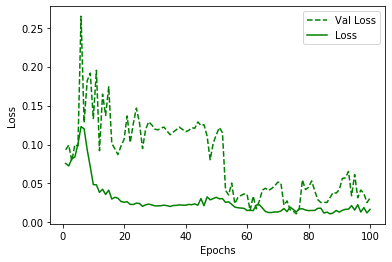

In [75]:
job_folder = 'C://Users/yacine/Desktop/thesis/models/lstm/IBM'


from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

snapshot = ModelCheckpoint(os.path.join(job_folder,
               'LSTM_2{epoch:03d}__{val_loss:.6f}.h5'),period=1,save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',patience=200)
history =model_lstm.fit(X_train, y_train,validation_split=0.1 ,epochs = 100, batch_size = 32 ,callbacks=[snapshot, earlystop] , shuffle=False)
n_epoch = len(history.history['loss'])
plt.plot(range(1, n_epoch+1),history.history['val_loss'],'g--',label='Val Loss')
plt.plot(range(1, n_epoch+1),history.history['loss'],'g-',label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(job_folder, 'train_val_loss_2.png'))

In [76]:
scaler.scale_

array([6.2814071e-03, 6.2386920e-03, 6.2216134e-03, 6.2216134e-03,
       2.4888127e-08, 7.9544457e-03, 3.1887190e+00, 2.7931542e+00,
       2.4150505e+00, 2.4511874e+00, 4.6767374e-03, 4.6905857e-03,
       4.9729310e-03, 6.8563791e-03, 1.8008284e-02, 1.6133249e-02,
       2.0438637e-09, 9.9999998e-03, 6.8005752e-03, 6.5345108e-03,
       1.2356739e-02, 2.4888127e-08], dtype=float32)

In [77]:
normal_scale = 1/6.2814071e-03
normal_scale

159.19999835705602

In [78]:
#Model creation for the test
import tensorflow as tf
loaded_model=tf.keras.Sequential()
loaded_model.add(tf.keras.layers.LSTM(units=75,return_sequences= True, input_shape=(X_train.shape[1], X_train.shape[2])))

loaded_model.add(tf.keras.layers.LSTM(units=30,return_sequences= True))


loaded_model.add(tf.keras.layers.LSTM(units=30))

loaded_model.add(tf.keras.layers.Dense(units=1))
loaded_model.summary()
loaded_model.load_weights(os.path.join(job_folder,"LSTM_2076__0.011009.h5"))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 75)            29400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 30)            12720     
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 49,471
Trainable params: 49,471
Non-trainable params: 0
_________________________________________________________________


In [79]:
y_pred = loaded_model.predict(X_test)
y_pred

array([[0.6155088 ],
       [0.61452186],
       [0.636985  ],
       [0.6389084 ],
       [0.6568381 ],
       [0.6618901 ],
       [0.6605855 ],
       [0.6390048 ],
       [0.6462444 ],
       [0.649211  ],
       [0.663035  ],
       [0.6500901 ],
       [0.6392737 ],
       [0.64511615],
       [0.65365106],
       [0.6570972 ],
       [0.65325457],
       [0.65939695],
       [0.6629073 ],
       [0.66168326],
       [0.66308504],
       [0.6768121 ],
       [0.66938525],
       [0.647307  ],
       [0.684493  ],
       [0.6693546 ],
       [0.6788986 ],
       [0.6946115 ],
       [0.69417906],
       [0.7040506 ],
       [0.7158976 ],
       [0.7233296 ],
       [0.713852  ],
       [0.7320066 ],
       [0.7330244 ],
       [0.732633  ],
       [0.7205587 ],
       [0.72209525],
       [0.7348158 ],
       [0.72743106],
       [0.7195739 ],
       [0.7258433 ],
       [0.7430281 ],
       [0.73583955],
       [0.7362212 ],
       [0.740197  ],
       [0.74498695],
       [0.742

In [80]:
y_pred.shape

(896, 1)

In [81]:
y_test_Scaled = y_test * normal_scale
y_test_Scaled


array([100.58999 , 103.99999 , 104.22001 , 106.30001 , 108.65002 ,
       108.19    , 106.380005, 104.55    , 104.200005, 106.9     ,
       105.630005, 103.92    , 105.84    , 106.1     , 107.14    ,
       106.85001 , 105.770004, 106.630005, 107.3     , 106.04001 ,
       108.26001 , 107.28    , 105.16001 , 109.939995, 110.68001 ,
       109.299995, 115.21001 , 114.15    , 114.79    , 117.99    ,
       118.43001 , 117.579994, 117.30001 , 119.600006, 117.53001 ,
       117.35    , 115.28    , 116.630005, 116.290016, 114.79    ,
       116.040016, 117.7     , 117.710014, 116.790016, 117.049995,
       117.74    , 117.439995, 116.689995, 115.42    , 115.78    ,
       115.14    , 114.65    , 114.34    , 113.75    , 114.85999 ,
       113.90001 , 112.21001 , 110.579994, 109.320015, 112.69    ,
       113.74    , 111.60001 , 110.29001 , 110.69999 , 111.15    ,
       112.02    , 111.72001 , 111.64    , 113.27001 , 112.13999 ,
       111.43    , 110.11    , 108.65002 , 107.3     , 108.909

In [82]:
y_pred_Scaled = y_pred * normal_scale
y_pred_Scaled

array([[ 97.989   ],
       [ 97.83188 ],
       [101.40801 ],
       [101.71421 ],
       [104.56863 ],
       [105.3729  ],
       [105.165215],
       [101.72957 ],
       [102.88211 ],
       [103.354385],
       [105.55517 ],
       [103.49434 ],
       [101.77237 ],
       [102.70249 ],
       [104.06125 ],
       [104.60988 ],
       [103.99812 ],
       [104.97599 ],
       [105.53484 ],
       [105.33997 ],
       [105.56313 ],
       [107.74849 ],
       [106.56613 ],
       [103.05127 ],
       [108.97128 ],
       [106.56126 ],
       [108.08065 ],
       [110.582146],
       [110.513306],
       [112.084854],
       [113.9709  ],
       [115.15407 ],
       [113.64523 ],
       [116.53545 ],
       [116.69749 ],
       [116.63517 ],
       [114.712944],
       [114.957565],
       [116.982666],
       [115.80702 ],
       [114.55617 ],
       [115.55425 ],
       [118.29007 ],
       [117.14565 ],
       [117.20641 ],
       [117.83936 ],
       [118.60192 ],
       [118.2

In [83]:
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

print('MSE: '+str(mean_squared_error(y_test_Scaled, y_pred_Scaled)))
print('MAE: '+str(mean_absolute_error(y_test_Scaled, y_pred_Scaled)))
print('RMSE: '+str(sqrt(mean_squared_error(y_test_Scaled, y_pred_Scaled))))
print('MAPE: '+str(np.mean(np.abs(y_pred_Scaled - y_test_Scaled)/np.abs(y_test_Scaled))))
print('R2: '+str(r2_score(y_test_Scaled, y_pred_Scaled)))


MSE: 5.263423
MAE: 1.7976543
RMSE: 2.2942151089214406
MAPE: 0.14178357
R2: 0.9616279871239765


In [84]:
y_pred_Scaled.shape

(896, 1)

In [85]:
acc=round((y_test_Scaled.mean() / y_pred_Scaled.mean())*100,2)
acc

100.69

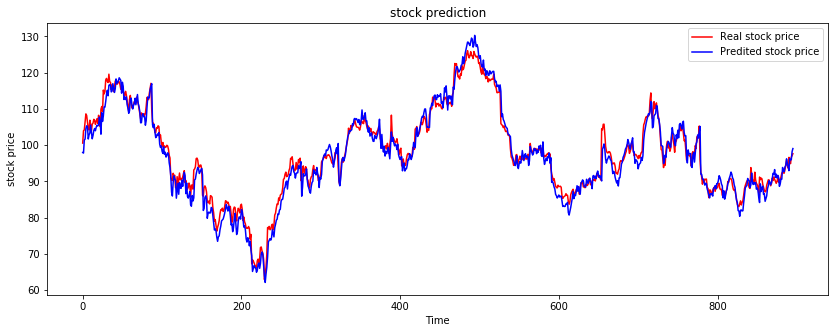

In [86]:
#Visualization LSTM
plt.figure(figsize=(14,5))
plt.plot(y_test_Scaled, color='red', label='Real stock price')
plt.plot(y_pred_Scaled, color='blue', label='Predited stock price')
plt.title('stock prediction')
plt.xlabel('Time')
plt.ylabel('stock price')
plt.legend()
plt.show()

In [87]:
#Model GRU
model_gru=tf.keras.Sequential()
model_gru.add(tf.keras.layers.GRU(units=75,return_sequences= True, input_shape=(X_train.shape[1], X_train.shape[2])))

model_gru.add(tf.keras.layers.GRU(units=30,return_sequences= True))


model_gru.add(tf.keras.layers.GRU(units=30))

model_gru.add(tf.keras.layers.Dense(units=1))
model_gru.compile(loss = 'mae' , optimizer = 'adam')
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 75)            22275     
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 30)            9630      
_________________________________________________________________
gru_2 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 37,516
Trainable params: 37,516
Non-trainable params: 0
_________________________________________________________________


In [88]:
(X_train.shape[1], X_train.shape[2])

(60, 22)

Train on 3386 samples, validate on 377 samples
Epoch 1/100
3386/3386 [==============================] - 45s 13ms/sample - loss: 0.0723 - val_loss: 0.0766
Epoch 2/100
3386/3386 [==============================] - 31s 9ms/sample - loss: 0.0508 - val_loss: 0.0852
Epoch 3/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0437 - val_loss: 0.0983
Epoch 4/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0378 - val_loss: 0.0806
Epoch 5/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0310 - val_loss: 0.0783
Epoch 6/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0250 - val_loss: 0.0683
Epoch 7/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0212 - val_loss: 0.0683
Epoch 8/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0235 - val_loss: 0.1036
Epoch 9/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0213 - val_loss: 0.065

3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0145 - val_loss: 0.0502
Epoch 78/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0134 - val_loss: 0.0208
Epoch 79/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0143 - val_loss: 0.0155
Epoch 80/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0155 - val_loss: 0.0209
Epoch 81/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0167 - val_loss: 0.0595
Epoch 82/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0230 - val_loss: 0.0163
Epoch 83/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0141 - val_loss: 0.0707
Epoch 84/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0192 - val_loss: 0.0288
Epoch 85/100
3386/3386 [==============================] - 30s 9ms/sample - loss: 0.0120 - val_loss: 0.0368
Epoch 86/100
3386/3386 [==========================

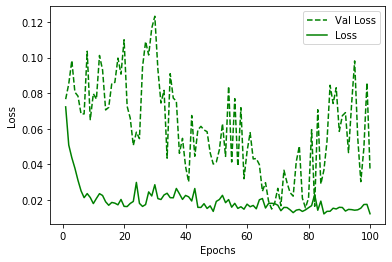

In [89]:
job_folder = 'C://Users/yacine/Desktop/thesis/models/gru/IBM'


from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

snapshot = ModelCheckpoint(os.path.join(job_folder,
               'GRU_2{epoch:03d}__{val_loss:.6f}.h5'),period=1,save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',patience=200)
history =model_gru.fit(X_train, y_train,validation_split=0.1 ,epochs = 100, batch_size = 32 ,callbacks=[snapshot, earlystop] , shuffle=False)
n_epoch = len(history.history['loss'])
plt.plot(range(1, n_epoch+1),history.history['val_loss'],'g--',label='Val Loss')
plt.plot(range(1, n_epoch+1),history.history['loss'],'g-',label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(job_folder, 'train_val_loss_2.png'))

In [90]:
#Model creation gru for the test
import tensorflow as tf
loaded_model1=tf.keras.Sequential()
loaded_model1.add(tf.keras.layers.GRU(units=75,return_sequences= True, input_shape=(X_train.shape[1], X_train.shape[2])))

loaded_model1.add(tf.keras.layers.GRU(units=30,return_sequences= True))


loaded_model1.add(tf.keras.layers.GRU(units=30))

loaded_model1.add(tf.keras.layers.Dense(units=1))
loaded_model1.summary()
loaded_model1.load_weights(os.path.join(job_folder,"GRU_2068__0.014780.h5"))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 60, 75)            22275     
_________________________________________________________________
gru_4 (GRU)                  (None, 60, 30)            9630      
_________________________________________________________________
gru_5 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 37,516
Trainable params: 37,516
Non-trainable params: 0
_________________________________________________________________


In [91]:
y_pred1 = loaded_model1.predict(X_test)
y_pred1

array([[0.6181311 ],
       [0.6158487 ],
       [0.63049364],
       [0.63443506],
       [0.6469676 ],
       [0.6544627 ],
       [0.64937156],
       [0.6304874 ],
       [0.63183475],
       [0.637052  ],
       [0.6490442 ],
       [0.63870835],
       [0.62944204],
       [0.6364346 ],
       [0.6413446 ],
       [0.6462739 ],
       [0.64414   ],
       [0.64663786],
       [0.6502448 ],
       [0.649809  ],
       [0.6472444 ],
       [0.66018736],
       [0.65467536],
       [0.6370737 ],
       [0.66662717],
       [0.6636836 ],
       [0.66448927],
       [0.68949205],
       [0.687051  ],
       [0.69512886],
       [0.7094175 ],
       [0.7125185 ],
       [0.70226675],
       [0.7175595 ],
       [0.7188039 ],
       [0.71331066],
       [0.70528275],
       [0.7048834 ],
       [0.71991634],
       [0.712171  ],
       [0.7059162 ],
       [0.71640515],
       [0.7305947 ],
       [0.7260591 ],
       [0.72502786],
       [0.72826403],
       [0.73386866],
       [0.732

In [92]:
y_pred_Scaled1 = y_pred1 * normal_scale
y_pred_Scaled1

array([[ 98.40647 ],
       [ 98.04311 ],
       [100.37459 ],
       [101.00206 ],
       [102.99724 ],
       [104.19046 ],
       [103.37995 ],
       [100.37359 ],
       [100.58809 ],
       [101.41868 ],
       [103.327835],
       [101.682365],
       [100.20717 ],
       [101.32039 ],
       [102.10206 ],
       [102.8868  ],
       [102.54709 ],
       [102.94475 ],
       [103.51897 ],
       [103.44959 ],
       [103.041306],
       [105.10183 ],
       [104.22432 ],
       [101.42213 ],
       [106.127045],
       [105.658424],
       [105.78669 ],
       [109.76713 ],
       [109.37852 ],
       [110.66451 ],
       [112.93927 ],
       [113.432945],
       [111.800865],
       [114.23547 ],
       [114.43358 ],
       [113.55905 ],
       [112.28101 ],
       [112.21744 ],
       [114.61068 ],
       [113.377625],
       [112.38186 ],
       [114.0517  ],
       [116.31068 ],
       [115.5886  ],
       [115.42443 ],
       [115.93963 ],
       [116.83189 ],
       [116.5

In [93]:
acc1=round((y_test_Scaled.mean() / y_pred_Scaled1.mean())*100,2)
acc1

102.48

In [94]:
print('MSE: '+str(mean_squared_error(y_test_Scaled, y_pred_Scaled1)))
print('MAE: '+str(mean_absolute_error(y_test_Scaled, y_pred_Scaled1)))
print('RMSE: '+str(sqrt(mean_squared_error(y_test_Scaled, y_pred_Scaled1))))
print('MAPE: '+str(np.mean(np.abs(y_pred_Scaled1 - y_test_Scaled)/np.abs(y_test_Scaled))))
print('R2: '+str(r2_score(y_test_Scaled, y_pred_Scaled1)))

MSE: 14.983348
MAE: 3.207629
RMSE: 3.870832971436669
MAPE: 0.14608413
R2: 0.8907666646067688


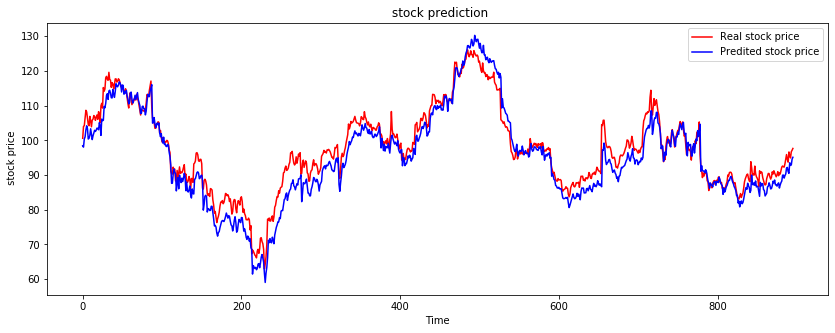

In [95]:
#Visualization GRU
plt.figure(figsize=(14,5))
plt.plot(y_test_Scaled, color='red', label='Real stock price')
plt.plot(y_pred_Scaled1, color='blue', label='Predited stock price')
plt.title(' stock prediction')
plt.xlabel('Time')
plt.ylabel(' stock price')
plt.legend()
plt.show()

In [96]:

predictions_lstm_IBM = pd.DataFrame(data=y_pred_Scaled, columns=['IBM_close_lstm_pred'])
predictions_lstm_IBM
predictions_lstm_IBM.to_csv(r'C:\Users\yacine\Desktop\thesis\pred\lstm\IBM.csv')

In [ ]:
predictions_lstm_IBM

In [97]:

predictions_gru_IBM = pd.DataFrame(data=y_pred_Scaled1, columns=['IBM_close_gru_pred'])
predictions_gru_IBM
predictions_gru_IBM.to_csv(r'C:\Users\yacine\Desktop\thesis\pred\gru\IBM.csv')